In [1]:
import numpy as np
import os
import csv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
matches = np.loadtxt("../results/queries_25.txt", delimiter='),(', dtype=str)
plt.rcParams.update({'font.size': 22})

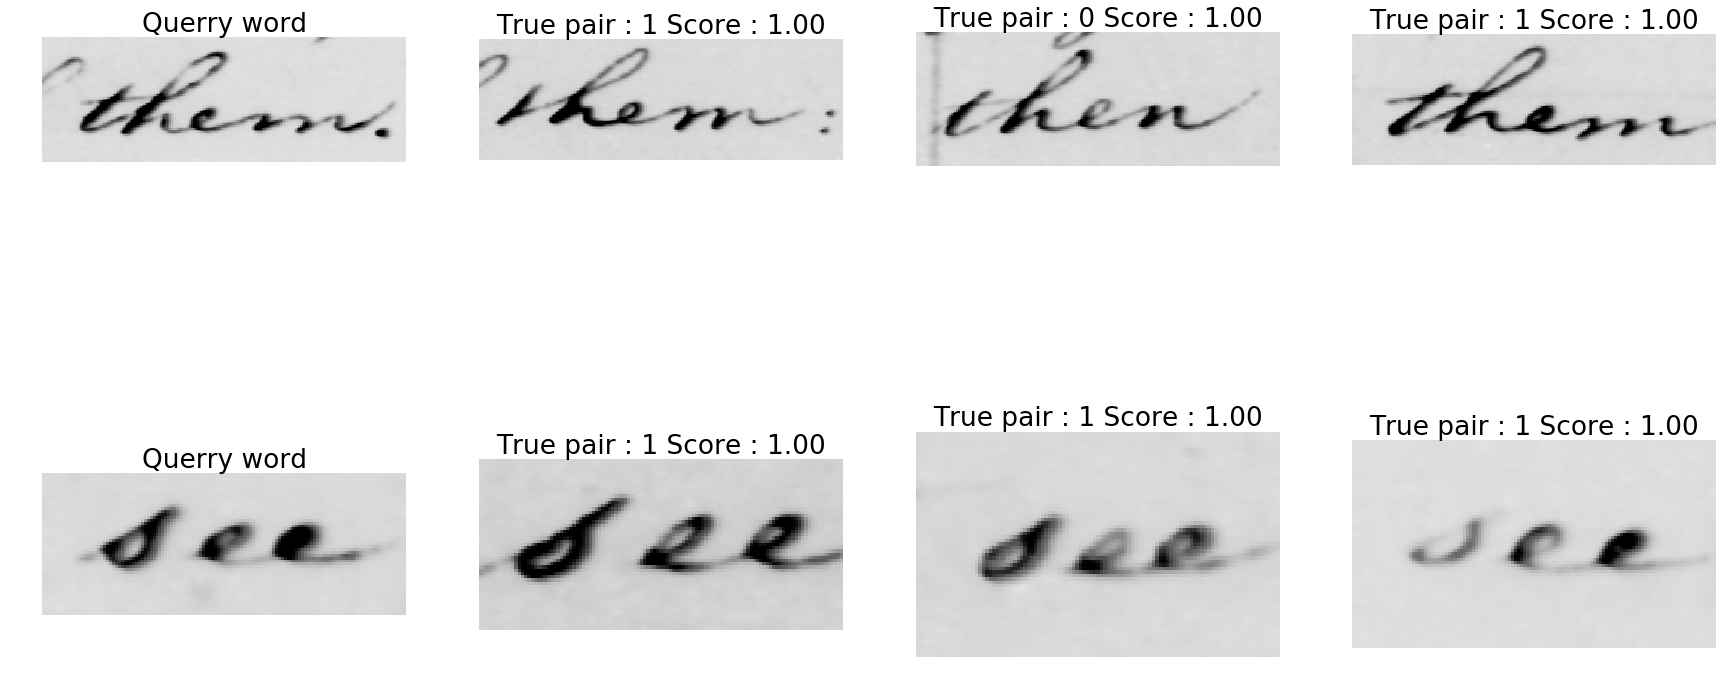

In [3]:
words = 2
first_bests = 3
nquerries, res = matches.shape

plt.figure(figsize=(30,15))

np.random.shuffle(matches)
for i,qr in enumerate(matches[:words]):
    querry, best = qr[0].split(',(')
    idx, score, pair = best.split(', ')
    plt.subplot(words, first_bests+1, 1 + i*(first_bests+1))
    im = Image.open('../dataset/word-{:06d}.png'.format(int(querry)+1))
    plt.imshow(im)
    plt.axis('off')
    plt.title('Querry word')
    
    plt.subplot(words, first_bests+1, 2 + i*(first_bests+1))
    im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)+1))
    plt.imshow(im)
    plt.axis('off')
    plt.title('True pair : {} Score : {:.2f}'.format(int(pair),float(score)))
    for j in range(first_bests-1):
        idx, score, pair = qr[1+j].split(', ')
        plt.subplot(words, first_bests+1, 3 + j + i*(first_bests+1))
        im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)+1))
        plt.imshow(im)
        plt.axis('off')
        plt.title('True pair : {} Score : {:.2f}'.format(int(pair),float(score)))

plt.show()